In [ ]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage as ski
import tqdm
from scipy.signal import find_peaks, peak_widths
import seaborn as sns
import pandas as pd
from pathlib import Path
import pickle as pkl
from sklearn.neighbors import KernelDensity
from  scipy.stats import gaussian_kde


cwd = Path().resolve()

In [ ]:
# Define overall variables used to analyze the data
resolution = 16.81E-6 # adding resolution in meters
lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
poreDiamThresh = 20
poreVolumeCutoff = 38000
simPressure = 0.00005 # This is currently hardcoded!!
imageSize = 512
experimentTime = 90 * 10 ** float(-6) # specify NMR time

filePath = cwd / 'subBeadPackPy512_justSpheres.npy'
primaryImage = np.load(filePath)

filePath = cwd / 'finalSimFile3D512.npy'
secondaryImage = np.load(filePath)
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

filePath = cwd / 'primarySnowOut.npy'
primarySnow = np.load(filePath)
filePath = cwd / 'primaryPoreInfo.p'
#primaryInfo = np.load(filePath,allow_pickle=True)
poreInfoPrimary = pkl.load(open(filePath,'rb'))

filePath = cwd / 'secondarySnowOut.npy'
secondarySnow = np.load(filePath)
filePath = cwd / 'secondaryPoreInfo.p'
#secondaryInfo = np.load(filePath,allow_pickle=True)
poreInfoSecondary = pkl.load(open(filePath,"rb"))


In [ ]:
filePath = cwd / 'velocityFiles' / 'velocityNormCodeSecondary_0.00005.mat'
velSecondaryMat = sio.loadmat(filePath)
velDataNormSecondary = velSecondaryMat['velNorm']

filePath = cwd / 'velocityFiles' / 'velocityNormCodePrimary_0.00005.mat'
velPrimaryMat = sio.loadmat(filePath)
velDataNormPrimary = velPrimaryMat['velNorm']


In [ ]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')

In [ ]:
plt.imshow(ps.tools.randomize_colors(secondarySnow[:,:,slice]), origin='lower')
plt.savefig('secondaryRegions.png', dpi=300, facecolor='w', edgecolor='w')


In [ ]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Primary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')

### Load all the data

In [ ]:
intraPoreMeanPoreVelocity = np.load('intraPore_meanVel.npy')
intraPore_metric_PoreVelocity = np.load('intraPore_metricVel.npy')
intraPoreVolumeVector = np.load('intraPoreVolumeVector.npy')
intraPoreVelocityDataframe = np.load('intraPoreVelocityDataframe.npy')
intraPoreVolumeDataframe = np.load('intraPoreVolumeDataframe.npy')

maskedSecondaryMeanPoreVelocity = np.load('maskedPore_meanVel.npy')
maskedSecondary_metric_PoreVelocity = np.load('maskedPore_metricVel.npy')
maskedSecondaryPoreVolumeVector = np.load('maskedPoreVolumeVector.npy')
maskedSecondaryPoreVolumeDataframe = np.load('maskedPoreVolumeDataframe.npy')
maskedSecondaryPoreVelocityDataframe = np.load('maskedPoreVelocityDataframe.npy')

df_secondaryVelocity = pd.read_pickle('secondaryVelocities.pkl')

## Format Dataframe


In [ ]:
copyInterGrainPoreVol = np.array(df_secondaryVelocity["Intergrain Pore Volume"])
filtInterGrainVel = np.zeros(copyInterGrainPoreVol.shape)
for a in range(len(copyInterGrainPoreVol)):
    if np.isnan(copyInterGrainPoreVol[a]):
        filtInterGrainVel[a] = 0
    else:
        filtInterGrainVel[a] = copyInterGrainPoreVol[a]

In [ ]:
df_secondaryVelocity["Intragrain Pore Volume"] = df_secondaryVelocity["Intragrain Pore Volume"] - filtInterGrainVel

In [ ]:
df_secondaryVelocity

## Plot Pore Volume

In [ ]:
volumeBins = np.linspace(0, 200000, num=40)

fig, ax = plt.subplots()
sns.set_style('whitegrid')

sns.histplot(data=df_secondaryVelocity["Intergrain Pore Volume"],
     bins=volumeBins,color="orange", label="Intergranular Porosity")
sns.histplot(data=df_secondaryVelocity["Intragrain Pore Volume"],
     bins=volumeBins,color="dodgerblue", label="Intragranular Porosity")


#sns.displot(data=[df_secondaryVelocity["Intragrain Pore Volume"], df_secondaryVelocity["Intergrain Pore Volume"]],
#            bins=volumeBins)
plt.ylim([0,40])
plt.legend()
plt.ylabel('Pore Volume')

plt.plot([poreVolumeCutoff, poreVolumeCutoff],[0,200],'g',lw=1)

figStr = 'interAndIntraPoreVolume_pressure_'+str(simPressure)+'.png'

plt.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


## Plot inter and intragranular porosity


In [ ]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)


binnedIntraVel = pd.cut(df_secondaryVelocity["Intragrain Median Velocity"], bins=bins, right=False)
binnedInterVel = pd.cut(df_secondaryVelocity["Intergrain Median Velocity"], bins=bins, right=False)
df_secondaryVelocity["binned_intraVelocity"] = binnedIntraVel
df_secondaryVelocity["binned_interVelocity"] = binnedIntraVel

yMax = 3000
velBins = np.linspace(0, 0.000025, num=40)

fig, ax = plt.subplots()
#fig.suptitle('Intra and inter pore velocities', fontsize=20)
sns.histplot(data=df_secondaryVelocity["Intragrain Median Velocity"],bins=velBins,
             ax=ax,color="dodgerblue", label="Intraparticle Median Velocity")
sns.histplot(data=df_secondaryVelocity["Intergrain Median Velocity"], bins=velBins,
             ax=ax, color="orange", label="Intergrain Median Velocity")
plt.legend()
ax.set_ylim([0,200])
ax.set_ylabel('Median Velocity')

lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
ax.plot([lowFlowVelCutoff , lowFlowVelCutoff],[0,200],'g',lw=1)

figStr = 'interAndIntraPoreVelocity_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')



## Plot both pore volume and median velocity

In [ ]:
########################################

yMax = 0.0001
xMax = 100000#np.max(df_secondaryVelocity["Intergrain Pore Volume"])

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Pore volume vs Median pore velocity for Pore Pressure ='+str(simPressure), fontsize=20)
sns.scatterplot(data=df_secondaryVelocity,x="Intergrain Pore Volume", y='Intergrain Median Velocity',ax=axes[0])
axes[0].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Velocity', fontsize=18)
axes[0].set_title('Intergranular Pores', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,xMax])
axes[0].plot([poreVolumeCutoff, poreVolumeCutoff],[0,yMax],'r',lw=5)
axes[0].plot([0,xMax],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

sns.scatterplot(data=df_secondaryVelocity, x="Intragrain Pore Volume", y='Intragrain Median Velocity',ax=axes[1])
axes[1].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Velocity', fontsize=18)
axes[1].set_title('Intragranular Pores', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,xMax])
axes[1].plot([poreVolumeCutoff, poreVolumeCutoff],[0,yMax],'r',lw=5)
axes[1].plot([0,xMax],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

figStr = 'poreVolumeVsPoreVelocity_zoomIn'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


In [ ]:
df_secondaryVelocity.count()

# IN PROGRESS RESEARCH BELOW

### Plot all pore velocities to add diffusion to

In [ ]:
# filter by pore space
allVelocities = velDataNormSecondary[secondaryImage == True]
# smush into one dimension
allVelocities = np.squeeze(allVelocities)

In [ ]:
np.max(allVelocities)

In [ ]:
allDisplacements = allVelocities * resolution * experimentTime
#allDisplacementNorm = allVelocitiesNorm * resolution * experimentTime # this is now in units of length

In [ ]:
np.max(allDisplacements)

## Plot histogram of displacements from velocity simulation

In [ ]:
displacementBins = np.linspace(1e-14, 1.5e-13, num=40)
#np.append(bins,0.0001)


data={'Displacement (m)': allDisplacements}
df_displacement = pd.DataFrame(data=data)

df_displacement['binned'] = pd.cut(df_displacement['Displacement (m)'], bins=displacementBins, right=False)


ax = sns.countplot(data=df_displacement, x='binned')
ax.tick_params(axis='x', labelrotation=90)


## Scale simulated displacements to be close to diffusion

In [ ]:
scaleExp = 9
allDisplacementsScaled = allDisplacements*(10**scaleExp);

## Simulate diffusion

In [ ]:
D_0 = 2.023 * 10 ** float(-9) # (m^2/s) for water at twenty degrees Celsius

#D_0 = 3.03 * 10 ** float(-9) # (m^2/s) from data?

T = 90000 * 10 ** float(-6) # (s) for 90000 us, same as NMR experiment
mean1DdiffusionLength = np.sqrt(2*D_0 * T)  # (m) Equation for diffusion in 2D
#diffusionVel = diffusionLength/T  # (m/s) Compute how fast diffusion is over T
print("The mean 1D calculated diffusion length is ", mean1DdiffusionLength, "m")

#randList = [-1,1]
#diffusionSign = np.random.choice(randList,len(df_secondaryVelocity["All secondary regions"]))
#diffusionDist = np.random.rand(len(df_secondaryVelocity["All secondary regions"]))

# FIXME: how is this defined really?m
# figure out sigma of diffusion distribution, currently sigma is set to diffusion length
#diffusionDist = np.random.normal(0,mean1DdiffusionLength,len(allVelocities))

# For this to work, import NMR data first!
diffusionDistVector = np.linspace(np.min(NMRDispScale),np.max(NMRDispScale), 999)
diffusionDist = ((4*np.pi*D_0*T)**(-1/2))*np.exp(-(diffusionDistVector)**2/(4*D_0*T))
#diffusionDist = np.random.normal(0,diffusionLength,6000)
# This distribution is in m

In [ ]:
diffusionDistNorm = diffusionDist / np.max(diffusionDist
                                           )
peaks, _ = find_peaks(diffusionDistNorm)
results_half = peak_widths(diffusionDistNorm, peaks, rel_height=0.5)

results_half[0]
diffusionDistNorm[int(np.round(results_half[3]))]
np.round(results_half[3])

In [ ]:
diffusionWidth = diffusionDistVector[int(np.round(results_half[3]))]-diffusionDistVector[int(np.round(results_half[2]))]
print(diffusionWidth)

In [ ]:
plt.plot(diffusionDistNorm)
plt.plot(peaks, diffusionDistNorm[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.show()

In [ ]:
np.max(diffusionDist)
#np.exp(-(diffusionDistVector)**2/(4*D_0*T))

In [ ]:
np.max(allDisplacementsScaled)

In [ ]:
displacementBinsScaled = np.linspace(np.min(NMRDispScale), np.max(NMRDispScale), num=1000)
#np.append(bins,0.0001)
#displacementBinsScaled = np.append(displacementBinsScaled, 3e-3)
#displacementBinsScaled = np.append(displacementBinsScaled, 5e-3)
#displacementBinsScaled = np.append(displacementBinsScaled, 7e-3)
#displacementBinsScaled = np.append(displacementBinsScaled, 1e-2)

#displacementBinsScaled = np.insert(displacementBinsScaled, 0, -1e-2)


In [ ]:
np.max(allDisplacements)

In [ ]:
np.max(allDisplacementsScaled)

In [ ]:
simulatedDisplacementCounts, bins = np.histogram(allDisplacementsScaled, bins=displacementBinsScaled)
#simulatedDisplacementCounts = np.array(simulatedDisplacementCounts[0:1])
simulatedDisplacementCounts = simulatedDisplacementCounts / np.max(simulatedDisplacementCounts)
#simulatedDisplacementCounts = simulatedDisplacementCounts / simulatedDisplacementCounts[25]

diffusionCounts, bins = np.histogram(diffusionDist,bins=displacementBinsScaled)
#diffusionCounts = np.array(diffusionCounts[0:1])
diffusionCounts = diffusionCounts / np.max(diffusionCounts)
#diffusionCounts = diffusionCounts / diffusionCounts[25]


In [ ]:
fig, ax = plt.subplots()

diffusionDistNorm = diffusionDist / np.max(diffusionDist)
#plt.bar(bins[:-1],diffusionCounts,width=5e-6)
ax.bar(bins[:-1],simulatedDisplacementCounts,width=5e-6)
ax.plot(diffusionDistVector,diffusionDistNorm, lw=4,  label='Diffusion')
ax.plot([mean1DdiffusionLength,mean1DdiffusionLength],[0,1])

ax.set_xlim(-1.5e-4, 1.5e-4)

#plt.hist(diffusionDist,bins=displacementBinsScaled)
#plt.hist(simulatedDisplacementCounts,bins=displacementBinsScaled)

## Load NMR data

In [ ]:
filePath = cwd / 'summedNMRDisp.mat'
NMR_dispData = sio.loadmat(filePath)
NMRDisp = NMR_dispData['summedDispData']

filePath = cwd / 'dispVectorOut_inMeters.mat' # load disp vector in meters
NMRDispScaleTemp = sio.loadmat(filePath)
NMRDispScale = NMRDispScaleTemp['dispVectorOut']

NMRDispNorm = NMRDisp / np.max(NMRDisp)
NMRDispNorm = np.transpose(NMRDispNorm)
NMRDispScale = np.transpose(NMRDispScale)


In [ ]:
np.max(NMRDispScale)

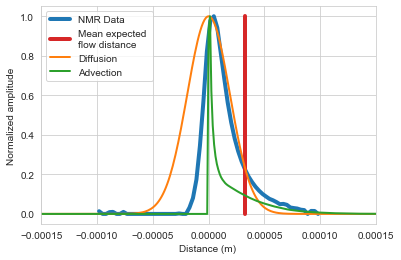

In [171]:
fig, ax = plt.subplots()

nPts = np.shape(NMRDispScale)
testScale = NMRDispScale * (1/(2 * np.pi))
#testSpace = np.linspace(-0.0001,0.0001,num=nPts[0])
ax.plot(testScale,NMRDispNorm, lw=4,  label='NMR Data')
#ax.plot(NMRDispScale,NMRDispNorm, lw=4,  label='NMR Data')
#ax.hist(diffusionCounts,bins=bins[:-1])

# Plot estimated mean flow distance given measured outflow
dMeanCalc = 3.271e-5
ax.plot([dMeanCalc,dMeanCalc],[0,1],lw=4,color='tab:red',label='Mean expected \nflow distance')
ax.plot(diffusionDistVector,diffusionDistNorm, lw=2,  label='Diffusion')
ax.plot(diffusionDistVector,simulatedDisplacementCounts,lw=2,label='Advection')
#ax.bar(bins[:-1],diffusionCounts,width=3e-6,alpha=0.5,label='Calculated Diffusion')
#bar(bins[:-1],simulatedDisplacementCounts,width=3e-6,alpha=0.5,label="Simulated \nScaled Advection")

ax.set_xlabel("Distance (m) ")
ax.set_ylabel("Normalized amplitude")
ax.legend(loc=2)
ax.grid(True)
ax.set_xlim(-1.5e-4, 1.5e-4)
figStr = 'allSimDisp.png'
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


In [170]:
NMRmeanAmp = np.mean(NMRDispNorm)
temp = np.abs(NMRmeanAmp-NMRDispNorm)
minInd = np.argmin(temp)
NMRmeanDisp = testScale[minInd]

meanSimDispAmp = np.mean(simulatedDisplacementCounts)
temp = np.abs(meanSimDispAmp-simulatedDisplacementCounts)
minInd = np.argmin(temp)
meanSimDisp = diffusionDistVector[minInd]

print("Mean expected displacement from outflow:" + str(np.mean(dMeanCalc)))
print("NMR measured mean displacement:" + str(np.squeeze(NMRmeanDisp)))
print("Mean simulated displacement:" + str(meanSimDisp))

Mean expected displacement from outflow:3.214e-05
NMR measured mean displacement:3.8937898724082944e-05
Mean simulated displacement:9.266455364009872e-05


In [151]:
minInd=np.argmin(temp)
print(minInd)

44


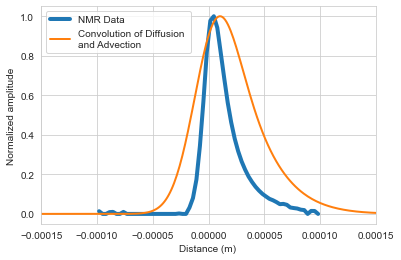

In [141]:
# Try to convolve diffusion and velocity distributions
computedDistance = np.convolve(diffusionDistNorm, simulatedDisplacementCounts,'same')
computedDistanceScale = computedDistance / np.max(computedDistance)

fig, ax = plt.subplots()

nPts = np.shape(NMRDispScale)
testScale = NMRDispScale * (1/(2 * np.pi))
#testSpace = np.linspace(-0.0001,0.0001,num=nPts[0])
ax.plot(testScale,NMRDispNorm, lw=4,  label='NMR Data')

ax.plot(diffusionDistVector,computedDistanceScale,lw=2,label='Convolution of Diffusion \nand Advection')

ax.set_xlabel("Distance (m) ")
ax.set_ylabel("Normalized amplitude")
ax.legend(loc=2)
ax.grid(True)
ax.set_xlim(-1.5e-4, 1.5e-4)

figStr = 'allSimDisp_convolve.png'
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


# Calculate flowing fraction for this data

In [ ]:
intergrainPoreCount = df_secondaryVelocity["Intergrain Pore Volume"].count()
print('Number of inter particle pores is',str(intergrainPoreCount))

# Final porosity calculation
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(np.round(porosityCalc,2))

# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1

### Refer to other code for less/more mobile calculation
## lowFlowCompute.py
